In [ ]:
# we import the necessary libraries
!pip install gensim==4.2.0
import gensim
gensim.__version__
import pandas as pd
import numpy as np
from gensim.utils import simple_preprocess
from gensim.models import FastText
import nltk
nltk.download("stopwords")
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn import cluster
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


K-Means Approach

In [ ]:
# we import the dataset
df = pd.read_json("Entity Recognition in Resumes.json", lines=True)
df.head()

,content,annotation,extras
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12...",NaN
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta...",NaN
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80...",NaN
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20...",NaN


In [ ]:
# we define a function to extract the required text from annotations
def get_text(row):
    text_data = []
    desired_labels = ["Designation", "College Name", "Degree"]
    for i in row:
        try:
            if i["label"][0] == "Skills":
                [text_data.append(j) for j in (i["points"][0]["text"]).split()]
            elif i["label"][0] in desired_labels:
                text_data.append(i["points"][0]["text"])
        except:
            continue
    text_data = list(set(text_data))
    return text_data

In [ ]:
# we apply our function on the dataset
df["text_data"] = df["annotation"].apply(get_text)

In [ ]:
# we remove the redundant columns from dataframe
df = df[["content", "text_data"]]

In [ ]:
df.head()

,content,text_data
0,Abhishek Jha\nApplication Development Associat...,"[Application Development Associate, Things, Sk..."
1,Afreen Jamadar\nActive member of IIIT Committe...,"[[…], Shivaji University Kolhapur , SQL, XML, ..."
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[Senior Systems Engineer, Jcl, Electrical and ..."
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[[…], SQL, 2005, studio, Reporting, Indira Gan..."
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[Frameworks:, Development:, Tomcat,, Js, Git, ..."


In [ ]:
df["content"] = df["content"].apply(lambda x: x.replace("\n", " ")) # replaced new lines with a space

In [ ]:
corp = []
ps = PorterStemmer()
for i in tqdm(df["content"]):
    review = re.sub('\W_',' ', i)        # removes specials characters and leaves only words
    review = re.sub("\S*\d\S*"," ", review)   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
    review = re.sub("\S*@\S*\s?"," ", review) # removes emails and mentions (words with @)
    review = re.sub(r'http\S+', '', review)   # removes URLs with http
    review = re.sub(r'www\S+', '', review)    # removes URLs with www
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    corp.append(" ".join(review))
df["content"] = corp

100%|██████████| 220/220 [00:22<00:00,  9.69it/s]


In [ ]:
df.head()

,content,text_data
0,abhishek jha applic develop associ - accentur ...,"[Application Development Associate, Things, Sk..."
1,afreen jamadar activ member iiit committe thir...,"[[…], Shivaji University Kolhapur , SQL, XML, ..."
2,"akhil yadav polemaina hyderabad, telangana - e...","[Senior Systems Engineer, Jcl, Electrical and ..."
3,alok khandai oper analyst (sql dba) engin - un...,"[[…], SQL, 2005, studio, Reporting, Indira Gan..."
4,"ananya chavan lectur - oracl tutori mumbai, ma...","[Frameworks:, Development:, Tomcat,, Js, Git, ..."


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["content"])
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

220 rows


,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
bot,0.336337,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
less,0.237283,0.253418,0.000000,0.00000,0.071831,0.118472,0.0,0.16019,0.0,0.084372,...,0.0,0.148188,0.0,0.119069,0.012799,0.0,0.000000,0.213035,0.000000,0.0
peoplesoft,0.214242,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
databas,0.203206,0.054256,0.024538,0.38504,0.000000,0.031706,0.0,0.00000,0.0,0.036128,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.012074,0.000000,0.012618,0.0
possibl,0.193214,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.023994,0.0


In [ ]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
bot,0.336337,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
less,0.237283,0.253418,0.000000,0.00000,0.071831,0.118472,0.0,0.16019,0.0,0.084372,...,0.0,0.148188,0.0,0.119069,0.012799,0.0,0.000000,0.213035,0.000000,0.0
peoplesoft,0.214242,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
databas,0.203206,0.054256,0.024538,0.38504,0.000000,0.031706,0.0,0.00000,0.0,0.036128,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.012074,0.000000,0.012618,0.0
possibl,0.193214,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.023994,0.0


In [ ]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [ ]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

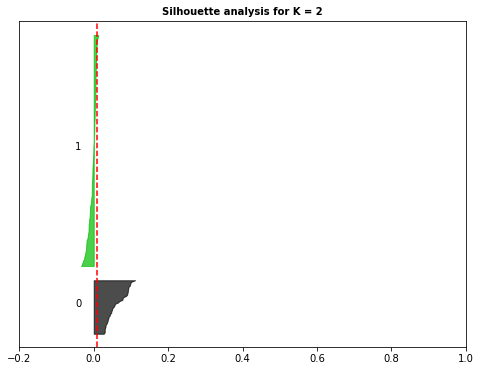

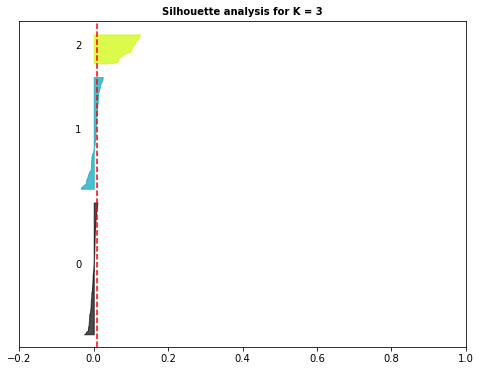

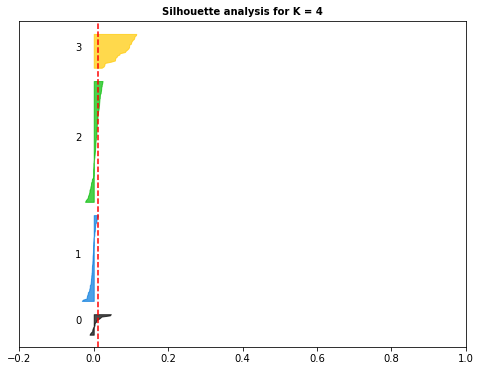

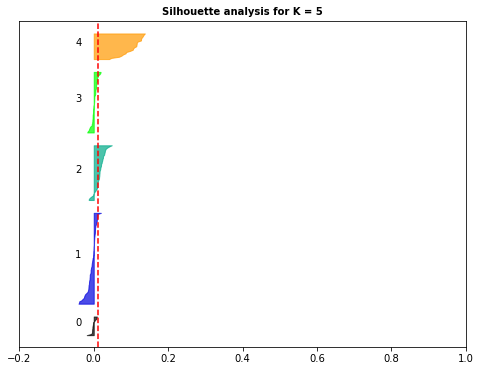

In [ ]:
# Running Kmeans
k = 5
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
silhouette(kmeans_results, final_df, plot=True)

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

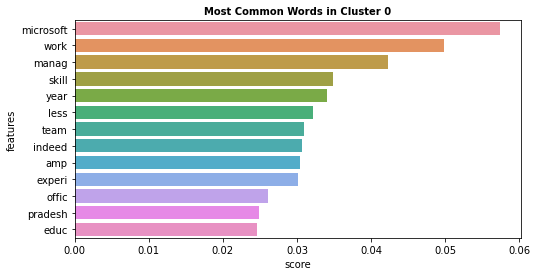

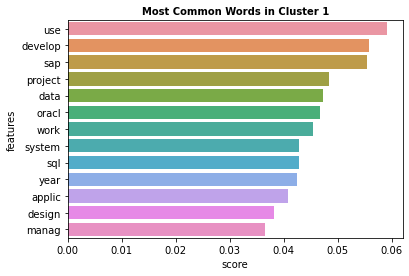

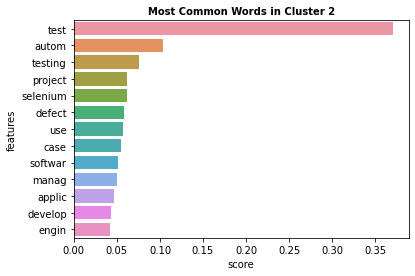

In [ ]:
best_result = 3
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

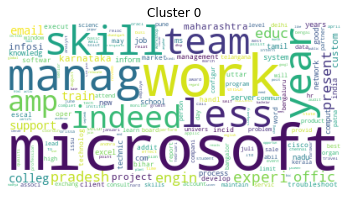

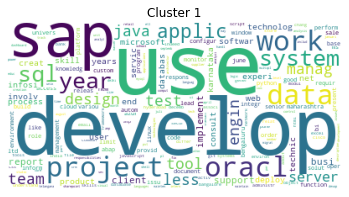

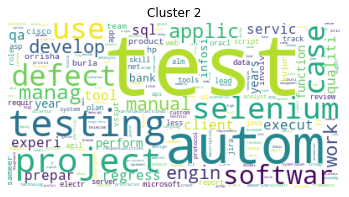

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [ ]:
# Assigning the cluster labels to back to dataframe
labels = kmeans.labels_ 
df['label'] = labels
df['label'] = df['label'].replace({0:"management", 1:"development", 2:"testing"})
df.head()

,content,text_data,label
0,abhishek jha applic develop associ - accentur ...,"[Application Development Associate, Things, Sk...",management
1,afreen jamadar activ member iiit committe thir...,"[[…], Shivaji University Kolhapur , SQL, XML, ...",development
2,"akhil yadav polemaina hyderabad, telangana - e...","[Senior Systems Engineer, Jcl, Electrical and ...",development
3,alok khandai oper analyst (sql dba) engin - un...,"[[…], SQL, 2005, studio, Reporting, Indira Gan...",development
4,"ananya chavan lectur - oracl tutori mumbai, ma...","[Frameworks:, Development:, Tomcat,, Js, Git, ...",development


In [ ]:
df["label"].value_counts()

management     106
development     90
testing         24
Name: label, dtype: int64

FastText Classification Approach

In [ ]:
# we import the dataset
df = pd.read_json("Entity Recognition in Resumes.json", lines=True)
df.head()

,content,annotation,extras
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12...",NaN
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta...",NaN
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80...",NaN
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20...",NaN


In [ ]:
# we apply our function on the dataset
df["text_data"] = df["annotation"].apply(get_text)
print(df["text_data"])

0      [Application Development Associate, Things, Sk...
1      [[…], Shivaji University Kolhapur , SQL, XML, ...
2      [Senior Systems Engineer, Jcl, Electrical and ...
3      [[…], SQL, 2005, studio, Reporting, Indira Gan...
4      [Frameworks:, Development:, Tomcat,, Js, Git, ...
                             ...                        
215    [Government Engineering College Bhuj, Student,...
216    [BACKUP, MAINTENANCE, year), LAN, Microsoft Az...
217    [ANALYST, 1, AUDITING, STATEMENT, Microsoft Of...
218    [Ramakrishna College, Project, (10+, Bharathia...
219    [SIEM, Splunk,, Security Analyst, ESM, Network...
Name: text_data, Length: 220, dtype: object


In [ ]:
# we pre-process the contents and tokenize them into lists
df["content"] = df["content"].apply(lambda x: simple_preprocess(x.replace("\n", " ")))
print(df["content"])

0      [abhishek, jha, application, development, asso...
1      [afreen, jamadar, active, member, of, iiit, co...
2      [akhil, yadav, polemaina, hyderabad, telangana...
3      [alok, khandai, operational, analyst, sql, dba...
4      [ananya, chavan, lecturer, oracle, tutorials, ...
                             ...                        
215    [mansi, thanki, student, jamnagar, gujarat, em...
216    [anil, kumar, microsoft, azure, basic, managem...
217    [siddharth, choudhary, microsoft, office, suit...
218    [valarmathi, dhandapani, investment, banking, ...
219    [pradeep, kumar, security, analyst, in, infosy...
Name: content, Length: 220, dtype: object


In [ ]:
# we preprocess our labels text data
prp_tokens = []
for row_token_list in df["text_data"]:
    prp_row_tokens = []
    prp_tokens.append(prp_row_tokens)
    for token in row_token_list:
        token_prp = simple_preprocess(token)
        if len(token_prp) != 0:
            prp_row_tokens.append(token_prp[0])
df["text_data"] = prp_tokens
print(df["text_data"])

0      [application, things, skills, peoplesoft, comp...
1      [shivaji, sql, xml, database, pg, ms, less, sy...
2      [senior, jcl, electrical, mainframe, anurag, t...
3      [sql, studio, reporting, indira, database, stu...
4      [frameworks, development, tomcat, js, git, jdb...
                             ...                        
215                            [government, student, be]
216    [backup, maintenance, year, lan, microsoft, sa...
217    [analyst, auditing, statement, microsoft, year...
218    [ramakrishna, project, bharathiar, master, inv...
219    [siem, splunk, security, esm, network, arc, ye...
Name: text_data, Length: 220, dtype: object


In [ ]:
df.head()

,content,annotation,extras,text_data
0,"[abhishek, jha, application, development, asso...","[{'label': ['Skills'], 'points': [{'start': 12...",NaN,"[application, things, skills, peoplesoft, comp..."
1,"[afreen, jamadar, active, member, of, iiit, co...","[{'label': ['Email Address'], 'points': [{'sta...",NaN,"[shivaji, sql, xml, database, pg, ms, less, sy..."
2,"[akhil, yadav, polemaina, hyderabad, telangana...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN,"[senior, jcl, electrical, mainframe, anurag, t..."
3,"[alok, khandai, operational, analyst, sql, dba...","[{'label': ['Skills'], 'points': [{'start': 80...",NaN,"[sql, studio, reporting, indira, database, stu..."
4,"[ananya, chavan, lecturer, oracle, tutorials, ...","[{'label': ['Degree'], 'points': [{'start': 20...",NaN,"[frameworks, development, tomcat, js, git, jdb..."


In [ ]:
# we create fasttext custom word embeddings in a vector space of 100 with the content data
model = FastText(vector_size=100, workers=6)
model.build_vocab(df["content"])
model.train(df["content"], total_examples=model.corpus_count, epochs=25)

(1967009, 2708950)

In [ ]:
# we get the similarity scores of every token in a tuple
similarity_tuples = []
for row in df["text_data"]:
    row_similarity_tuples = []
    similarity_tuples.append(row_similarity_tuples)
    for token in row:
        row_similarity_tuples.append((model.wv.similarity("tester", token), 
                                    model.wv.similarity("developer", token), 
                                    model.wv.similarity("management", token)))

In [ ]:
# we get the index of tokens with max similarity and take the index label with max count
class_labels = []
for row in similarity_tuples:
    tokens_list = [np.argmax(token) for token in row]
    class_labels.append(max(tokens_list,key=tokens_list.count))
df["class_label"] = class_labels

In [ ]:
# we replace the index with the actual class names
df["class_label"] = df["class_label"].replace({0:"testing", 1:"development", 2:"management"})
print(df["class_label"])

0       management
1      development
2          testing
3      development
4      development
          ...     
215     management
216     management
217     management
218     management
219     management
Name: class_label, Length: 220, dtype: object


In [ ]:
# we check the individual class label counts
df["class_label"].value_counts()

management     100
development     86
testing         34
Name: class_label, dtype: int64

In [ ]:
df.head()

,content,annotation,extras,text_data,class_label
0,"[abhishek, jha, application, development, asso...","[{'label': ['Skills'], 'points': [{'start': 12...",NaN,"[application, things, skills, peoplesoft, comp...",management
1,"[afreen, jamadar, active, member, of, iiit, co...","[{'label': ['Email Address'], 'points': [{'sta...",NaN,"[shivaji, sql, xml, database, pg, ms, less, sy...",development
2,"[akhil, yadav, polemaina, hyderabad, telangana...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN,"[senior, jcl, electrical, mainframe, anurag, t...",testing
3,"[alok, khandai, operational, analyst, sql, dba...","[{'label': ['Skills'], 'points': [{'start': 80...",NaN,"[sql, studio, reporting, indira, database, stu...",development
4,"[ananya, chavan, lecturer, oracle, tutorials, ...","[{'label': ['Degree'], 'points': [{'start': 20...",NaN,"[frameworks, development, tomcat, js, git, jdb...",development
